# **Symbolic Regression**

## 1. What is symbolic regression?

**Symbolic regression** is a _machine learning_ technique that finds a **symbolic expression** that matches data from an unknown function. In other words, it is a machinery able to identify an underlying mathematical expression that best describes a relationship between one or more variables. 

The symbolic regression problem for mathematical functions has been tackled with a variety of methods, including:

- **Sparse regression**: [Quade, et, al.](https://aip.scitation.org/doi/abs/10.1063/1.5027470?ai=1gvoi&mi=3ricys&af=R&), [Brunton, et al.](https://arxiv.org/pdf/1509.03580.pdf);
- **Genetic algorithms**: [GPTIPS](https://sites.google.com/site/gptips4matlab/) (`Matlab`), [gplearn](https://gplearn.readthedocs.io/en/stable/) (`Python`);
- [AI Feynman](https://advances.sciencemag.org/content/6/16/eaay2631/tab-pdf) (Tegmark).

## 2. How does it works?

It builds a set of random formulas to represent the relationship between known independent variables and their dependent variable targets in order to predict them. 

Each successive **step** (_generation_) of programs is then **transformed** (_evolved_) from the one that came before it (_by selecting the fittest individuals_) from the **data** (_population_) to undergo **next** (_genetic_) operations.

### 2.1. Representation

For example, to write the following expression:

\begin{equation}
 y = X^2_0 - 3 X_1 + 0.5
\end{equation}
we can rewrite it as
\begin{equation}
 y = X_0 \times X_0 - 3 \times X_1 + 0.5 .
\end{equation}

But we can do more, we can use a _LISP symbolic expression_:
\begin{equation}
 y = (+ ( - (\times X_0 X_0)(\times 3 X_1)) 0.5 )
\end{equation}
or even, we can understand is as a **syntax tree**, where the **interior nodes** are the _functions_ and the _variables_ and _constants_ are the **terminal nodes**:
![tree](https://gplearn.readthedocs.io/en/stable/_images/syntax_tree.png)

### 2.2 Fitness

It determines how well the program performs. As in other ML things, in GP we have to know whether the metric needs to be _maximized_ or _minimized_ in order to be able solve each specific problem:

- **Regression problems**:
    - `MSE`: mean squared error;
    - `RMSE`: root mean squared error;
    
- **Classification problems**:
    - `LOG LOSS`: logarithmic loss;
    - `BIN CROSS-ENTROPY`: binary cross-entropy loss;

### 2.3 Initialization

Compreehends the **parameters** that should be chosen to perform the symbolic operation:

- `population_size`: number of programs competing in the first generation and every generation thereafter;
- `function_set`: they are the available mathematical functions that  you want to pass;
- `generations`: the maximum number of steps until the programs stops;
- `stopping_criteria`:it defines a default number meaning a perfect score $\Rightarrow$ used to stop the program too;
- `p_crossover:` this crossover parameter is a percentage that takes the winner of a tournament and selects a random subtree from it to be replaced in the next generations;
- `p_subtree_mutation`: it is a more agressive operation. It basically is another percentage parameter that allows to reintroduce extinct functions and operators into the population to maintain diversity;
- `p_hoist_mutation`: another percentage parameter that is responsible to remove genetic material from tournament winners;
- `p_point_mutation`: crazy percentage parameter $\Rightarrow$ it takes the winner of a tournament and selects random nodes from it to be replaced;
- `max_samples:` increase the amount of subsampling performed on your data to get more diverse looks at individual programs from smaller portions of the data;
- `parsimony_coefficient`: controls the penalty given to fitness measure during selection.

## 2.4 Summarizing

![scheme](https://miro.medium.com/max/441/1*cNeNCpCjj1Tn3bh-30r09Q.png)

## 3. What we are going to use?

`gplearn` implements Genetic Programming in `Python`, with a scikit-learn inspired and compatible API.

![gplearn](https://miro.medium.com/max/700/1*T0LnkWyncmNhXLKc2zQusQ.png)

## 4. Symbolic Regressor Example

Here we will predict the Hublle evolution $H$ with the redshift $z$:

\begin{equation}
 H (z) = H_0 \sqrt{\Omega_k (1 + z)^2 + \Omega_m (1 + z)^3 + \Omega_r (1 + z)^4 + \Omega_{\Lambda}}
\end{equation}

where $H_0$ is the Hubble parameter, $\Omega_k$ is the curvature density, $\Omega_m$ is the matter density, $\Omega_r$ is the radiation density and $\Omega_{\Lambda}$ is the dark energy density of the Universe, all today.

### 4.1 Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

### 4.2 Initial dataset and data analysis

Initial dataset:

In [2]:
nsample = 1000
sig = 0.2

In [3]:
def Hz(z):
    H0 = 67.3
    Omega_m = 0.3115
    Omega_r = 2.473*10**(-5)
    Omega_de = 0.685
    Omega_k = 1. - Omega_m - Omega_r - Omega_de
    return H0*np.sqrt(Omega_k*(1 + z)**2 + Omega_m*(1 + z)**3 + Omega_r*(1 + z)**4 + Omega_de)

In [4]:
rng = check_random_state(0)
z = rng.uniform(0, 10, nsample)
H = Hz(z) + sig*np.random.normal(size=nsample)

In [5]:
data = np.array([z, H]).T
columns = ['z', 'H (z)']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,z,H (z)
0,5.488135,624.287137
1,7.151894,876.945822
2,6.027634,702.550795
3,5.448832,618.878539
4,4.236548,454.219849


Data visualization:

Text(0.5, 0, '$z$')

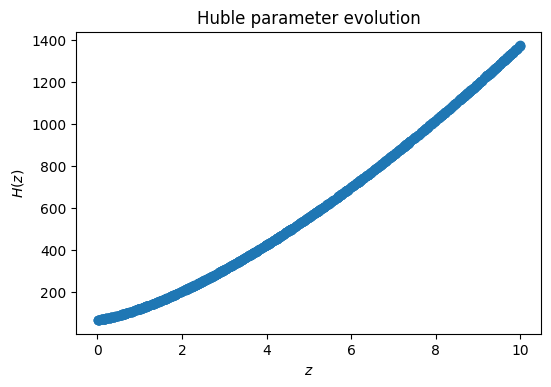

In [6]:
plt.figure(dpi = 100)
plt.title('Huble parameter evolution')
plt.scatter(df['z'], df['H (z)'])
plt.ylabel(r'$H (z)$')
plt.xlabel(r'$z$')

### 4.3 ML getting data:

In [7]:
X = df[['z']]
y = df['H (z)']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 1), (300, 1), (700,), (300,))

### 4.4 GPlearn implementation

#### 4.4.1 First test:

a) Choosing just some functions

In [8]:
function_set = ['add', 'sub', 'mul']

In [9]:
est_gp = SymbolicRegressor(population_size=5000,function_set=function_set,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

b) Fit:

In [10]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81      3.53838e+10       63          177.246          167.958      1.97m
   1    51.35           187098       63          143.405          141.207      1.61m
   2    63.31           197607      139          88.6634          83.3361      1.69m
   3    80.92      3.82144e+06      139          87.1473           80.188      1.70m
   4    73.40       1.7296e+06      143          85.3693          96.1901      1.51m
   5    88.35      2.55467e+06      135          82.2406          83.0213      1.59m
   6   123.16      6.42323e+09      129          58.0368          53.7706      1.70m
   7   142.64      8.53495e+09      129           49.992          52.5158      1.73m
   8   139.45      2.36822e+11      129          48.8323          44.3659  

c) Prediction

In [11]:
t0 = time.time()
y_gp1 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.003470182418823242 seconds


d) Score

In [12]:
score_gp1 = est_gp.score(X_test, y_test)
print('R2:', score_gp1)

R2: 0.9967157328344243


##### 4.4.1.1. **Visualizing the symbolic function**

a) Equation

In [13]:
converter = {
    'add': lambda x, y : x + y,
    'sub': lambda x, y : x - y,
    'mul': lambda x, y : x*y,
    'div': lambda x, y : x/y,
    'sqrt': lambda x : x**0.5,
    'log': lambda x : log(x),
    'abs': lambda x : abs(x),
    'neg': lambda x : -x,
    'inv': lambda x : 1/x,
    'max': lambda x, y : max(x, y),
    'min': lambda x, y : min(x, y),
    'sin': lambda x : sin(x),
    'cos': lambda x : cos(x),
    'pow': lambda x, y : x**y,
}

In [14]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

(3.928432*X0 + 7.036)*(-X0**2 + X0*(0.806*X0 + 1.681) + 2.806*X0 + 3.35)

b) Score

In [15]:
y_gp = est_gp.predict(X_test)
score_gp1 = est_gp.score(X_test, y_test)
score_gp1

0.9967157328344243

c) Plot

Text(0.5, 0, 'z')

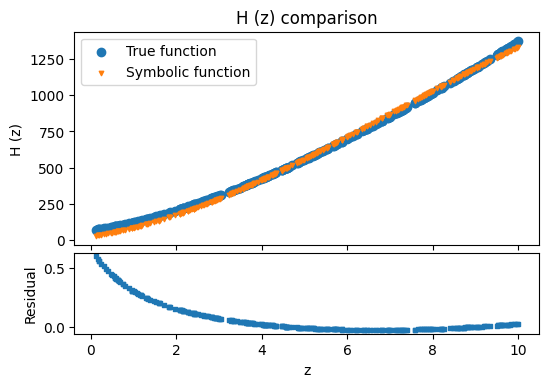

In [16]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp1, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp1/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

d) Tree

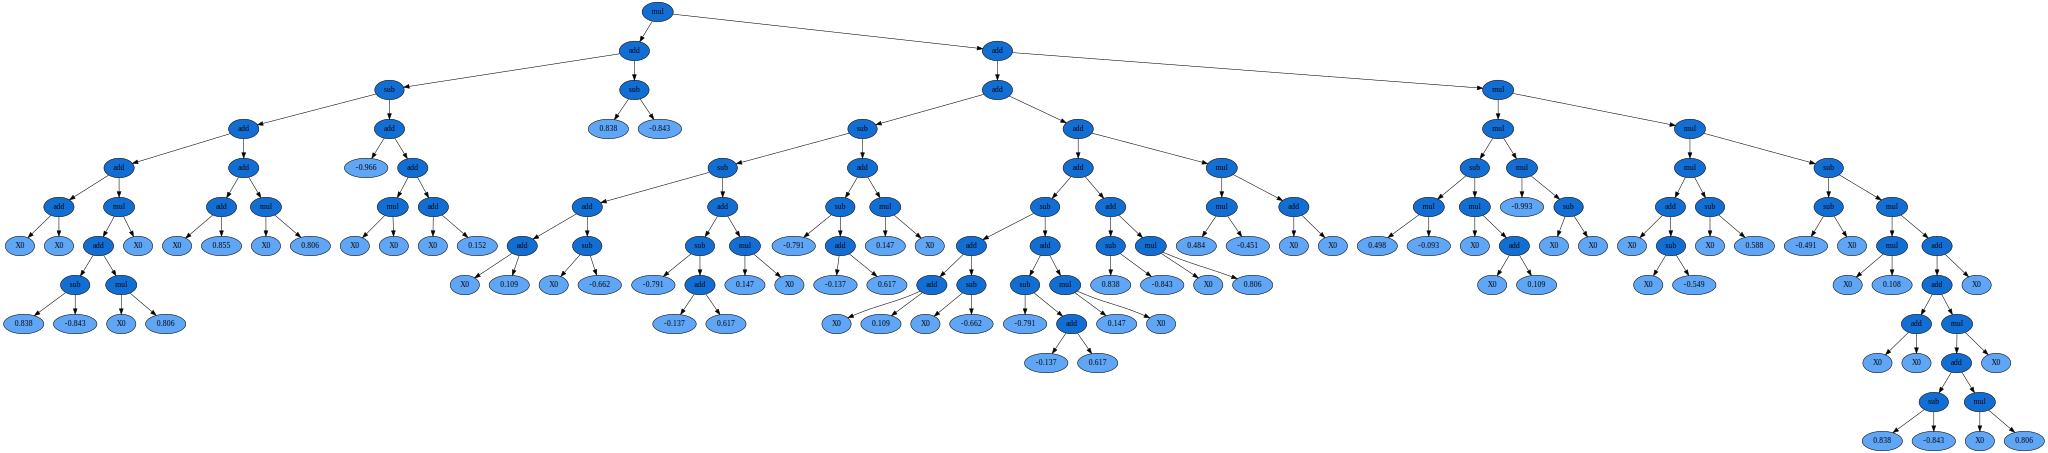

In [17]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1', format='png', cleanup=True)
graph

#### 4.4.2 Second test:

a) Don't imposing any function

In [18]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

b) Fit

In [19]:
t0 = time.time()
est_gp.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81      2.34608e+06        7          59.4318          66.2518      2.37m
   1    50.93          11966.8        7          59.0484          69.7024      2.06m
   2    58.86          5952.23       43          13.1229          14.6923      2.05m
   3    58.18          9087.44       43          11.0273          12.0974      1.90m
   4    62.73          11650.9       97          10.4827          10.7773      1.87m
   5    75.55          9385.07       47          10.1926          11.7112      1.97m
   6    56.27          6290.84       27          10.0121          13.1662      1.51m
   7    49.54          8367.19       49          9.88528          12.5177      1.30m
   8    41.17          14176.4       49          9.89063          12.4696  

c) Prediction

In [20]:
t0 = time.time()
y_gp2 = est_gp.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.002447843551635742 seconds


d) Score

In [21]:
score_gp2 = est_gp.score(X_test, y_test)
print('R2:', score_gp2)

R2: 0.9995898043073126


##### 4.4.2.1 **Visualizing the symbolic function**

a) Equation

In [22]:
next_e = sympify(str(est_gp._program), locals=converter)
next_e

0.373*X0*(X0**2 - 32.258064516129*(0.746*X0 - 1.072375)/(X0**2*(0.031*X0**2 + 0.001299272 + 0.214/X0))) + 100.762601626016*X0 - 0.36909918699187

b) Plot

Text(0.5, 0, 'z')

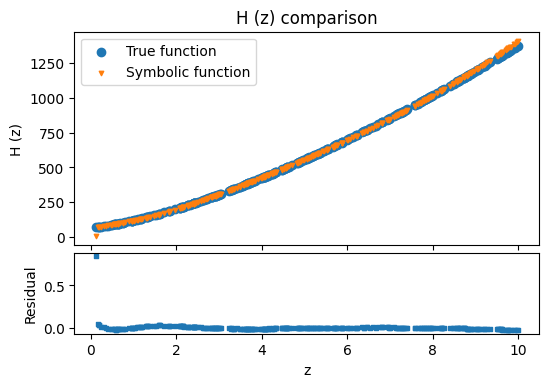

In [23]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_gp2, marker = 'v', s = 10, label = 'Symbolic function')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_gp2/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

c) Tree

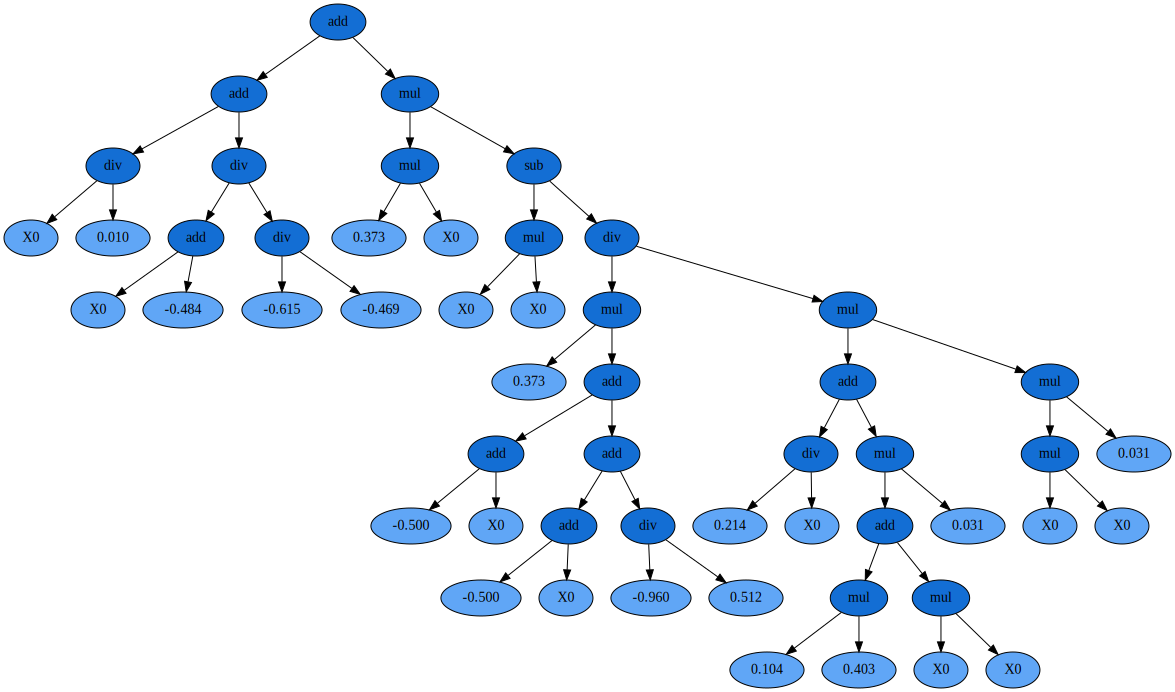

In [24]:
dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex2', format='png', cleanup=True)
graph

### 4.5 Comparing GPlearn to traditional ML approaches

#### 4.5.1 Decision Tree Regressor

a) Model and fit

In [25]:
est_tree = DecisionTreeRegressor(max_depth=5)
t0 = time.time()
est_tree.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

Time to fit: 0.014159202575683594 seconds


b) Prediction and score

In [26]:
t0 = time.time()
y_tree = est_tree.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.0028460025787353516 seconds


In [27]:
#Score
score_tree = est_tree.score(X_test, y_test)
print('DT:', score_tree)

DT: 0.998831678221913


c) Plot

Text(0.5, 0, 'z')

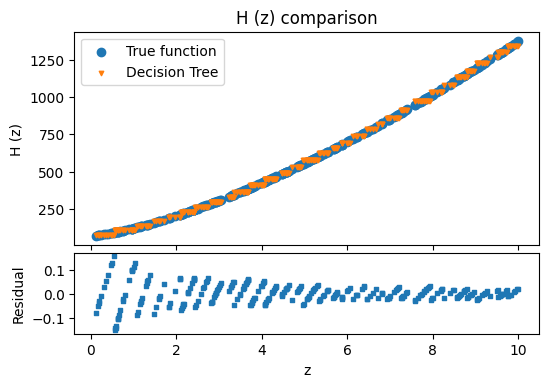

In [28]:
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_tree, marker = 'v', s = 10, label = 'Decision Tree')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_tree/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

#### 4.5.2 Random Forest Regressor

a) Model and Fit

In [29]:
est_rf = RandomForestRegressor(n_estimators=100,max_depth=5)
t0 = time.time()
est_rf.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

Time to fit: 0.22199487686157227 seconds


b) Prediction and Score

In [30]:
t0 = time.time()
y_rf = est_rf.predict(X_test)
print('Time to predict:', time.time() - t0, 'seconds')

Time to predict: 0.023862361907958984 seconds


In [31]:
score_rf = est_rf.score(X_test, y_test)
print('RF:', score_rf)

RF: 0.9998512936885466


c) Plot

Text(0.5, 0, 'z')

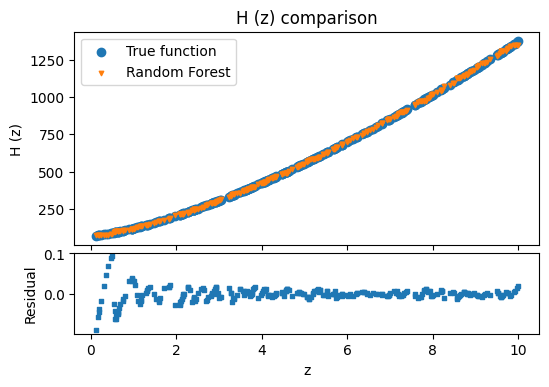

In [32]:
#Plot
fig = plt.figure(constrained_layout=False, dpi=100)
gs = fig.add_gridspec(nrows=7, ncols=1)
f_ax1 = fig.add_subplot(gs[0:5,0])
plt.title('H (z) comparison')
plt.scatter(X_test, y_test, label = 'True function')
plt.scatter(X_test, y_rf, marker = 'v', s = 10, label = 'Random Forest')
plt.legend()
plt.ylabel('H (z)')
f_ax2 = fig.add_subplot(gs[5:7, 0])
plt.scatter(X_test, 1. - y_rf/y_test, marker = 's', s = 10)
plt.ylabel('Residual')
plt.xlabel('z')

#### 4.5.3 All together

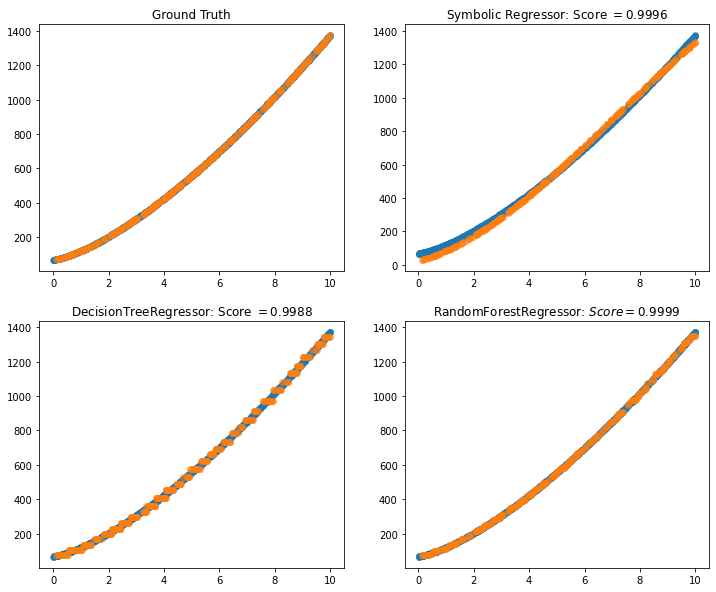

In [33]:
fig = plt.figure(figsize=(12, 10))
for i, (y, score, title) in enumerate([(y_test, None, "Ground Truth"),
                                       (y_gp, score_gp2, r"Symbolic Regressor: Score $= {:.4f}$".format(score_gp2)),
                                       (y_tree, score_tree, r"DecisionTreeRegressor: Score $= {:.4f}$".format(score_tree)),
                                       (y_rf, score_rf, r"RandomForestRegressor: $Score = {:.4f}$".format(score_rf))]):
    ax = fig.add_subplot(2, 2, i+1)
    points = ax.scatter(X, y_true, alpha=0.5)
    test = ax.scatter(X_test,y, alpha=0.5)
    plt.title(title)

## 5. Symbolic Classifier

The **SymbolicClassifier** works in exactly the same way as the **SymbolicRegressor** in how the evolution takes place. The only _difference_ is that the **output** of the program is _transformed_ through a **sigmoid function** in order to transform the numeric output into probabilities of each class. 

In essence this means that a negative output of a function means that the program is predicting one class, and a positive output predicts the other.

### 5.1 Importing libraries

In [34]:
from gplearn.genetic import SymbolicClassifier
from sklearn.datasets import load_boston
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### 5.2 Wisconsin breast cancer 

a) Loading:

In [35]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

b) Description:

In [36]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### 5.3 Data pre-processing

#### 5.5.1 Shuffling data

In [37]:
rng = check_random_state(0)
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

#### 5.5.2 Spliting data

In [38]:
X_train = cancer.data[:400]
y_train = cancer.target[:400]
X_test = cancer.data[400:]
y_test = cancer.target[400:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 30), (400,), (169, 30), (169,))

### 5.3 Classifying

In [39]:
est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)

#### 5.3.1 Fit

In [40]:
t0 = time.time()
est.fit(X_train, y_train)
print('Time to fit:', time.time() - t0, 'seconds')

Time to fit: 16.150514125823975 seconds


#### 5.3.2 Predicting

In [41]:
y_gpclas = est.predict_proba(X_test)[:,1]
y_gpclas.shape

(169,)

#### 5.3.3 Scoring

In [42]:
score = roc_auc_score(y_test, y_gpclas)
score

0.9693786982248521

### 5.4 Visualizing

a) ROC curve:

In [43]:
cutoff = 0.7
y_test_classes = np.zeros_like(y_test)
y_test_classes[y_test > cutoff] = 1

cutoff = 0.7
y_gpclas_classes = np.zeros_like(y_gpclas)
y_gpclas_classes[y_gpclas > cutoff] = 1

In [44]:
fpr, tpr, thresholds = roc_curve(y_test_classes, y_gpclas_classes)

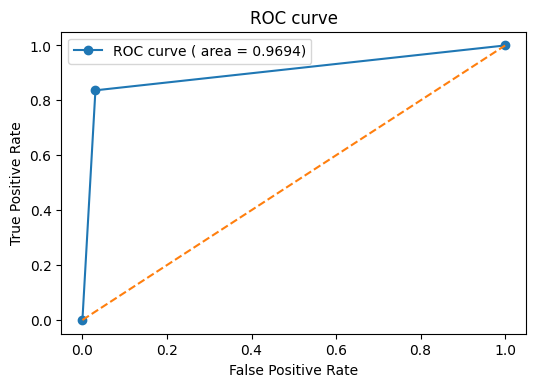

In [45]:
plt.figure(dpi=100)
plt.plot(fpr, tpr, '-o', label = r'ROC curve ( area = {:.4})'.format(score))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

b) Tree:

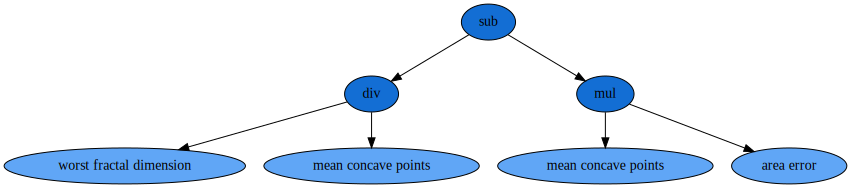

In [46]:
dot_data = est._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

## 6. References

- [Python symbolic Regression with GPlearn](https://medium.com/analytics-vidhya/python-symbolic-regression-with-gplearn-cbc24dbbc271)
- [GPlearn documentation](https://gplearn.readthedocs.io/en/stable/index.html)